In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.special import softmax
from matplotlib.collections import LineCollection

In [2]:
def make_helices(n_samples=1200, noise=0.05, n_helices=3):
    """Generate 3 intertwined helices."""
    t = np.linspace(np.pi, 4 * np.pi, n_samples // n_helices)
    X = []
    y = []

    for i in range(n_helices):
        theta = t + (i * 2 * np.pi / n_helices)
        x = t * np.cos(theta)
        z = t * np.sin(theta)
        y_coord = t * 0.5  # Stretch along Y

        # Stack and add noise
        helix = np.stack([x, y_coord, z], axis=1)
        helix += np.random.normal(scale=noise, size=helix.shape)

        X.append(helix)
        y.append(np.full(len(t), i))

    return np.vstack(X)[:,[0,2]], np.concatenate(y)

In [3]:
RANDOM_SEED = 42
N = 1200
K = 3
HELIX_NOISE = 0.25

MC_NUM_SAMPLES = 1024*16

MIN_TAU_LOG10 = -4.
MAX_TAU_LOG10 = 2.
NUM_TAU = 60

In [4]:
np.random.seed(RANDOM_SEED)
X, y_true = make_helices(n_samples=N, noise=HELIX_NOISE, n_helices=K)

In [5]:
np.random.seed(RANDOM_SEED)
logits = np.random.randn(N, K)
temperatures = np.logspace(MIN_TAU_LOG10, MAX_TAU_LOG10, NUM_TAU)

In [6]:
print("Computing Affinity Matrix (RBF)...")
dists = pairwise_distances(X, metric="euclidean")
# sigma = np.quantile(dists,axis=1, q=0.05, keepdims=True)  # Heuristic bandwidth
sigma = np.mean(dists,axis=1, keepdims=True)  # Heuristic bandwidth
sigma = sigma/10.0
W = np.exp(-(dists/sigma)**2 / 2 )
np.fill_diagonal(W, 0)
W = (W+W.T)/2.

Computing Affinity Matrix (RBF)...


In [7]:
D = W.sum(0)

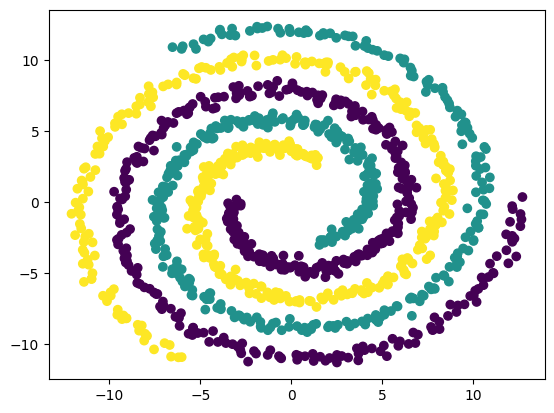

In [8]:
plt.scatter(X[:,0], X[:,1], c=y_true)

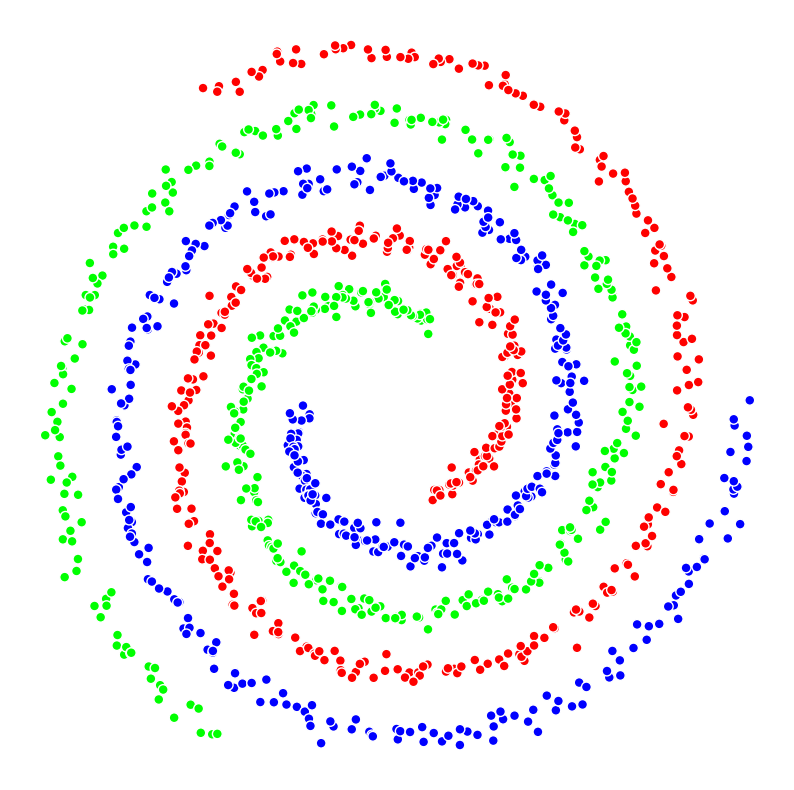

In [9]:
plt.figure(figsize=(10, 10))
ax = plt.gca()

# 5. Scatter Points
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y_true,
      cmap="brg",
    s=50,
    edgecolors="white",
    zorder=10,
)

# plt.title(
#     rf"Edges with $W_{{ij}} > {threshold}$, thickness $\propto W_{{ij}}$",
#     fontdict={'fontsize': 14}
# )
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.axis("equal")  # Important to keep the circular shape of the helix
# plt.grid(True, alpha=0.3)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.set_axis_off()
plt.savefig("figures/3_helices_true.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [11]:
threshold = 0.5
rows, cols = np.where(np.triu(W, 1) > threshold)
lines = []
widths = []
colors = []

for r, c in zip(rows, cols):

    lines.append([X[r], X[c]])
    widths.append(W[r, c] * 2.0)
    
    if y_true[r] == y_true[c]:
        colors.append((0, 0, 0, 0.3))
    else:
        colors.append((1, 0, 0, 0.6))


lines.append([[9,13],[10,13]])
widths.append( 2.0)
colors.append((0, 0, 0, 0.3))

lines.append([[9,12],[10,12]])
widths.append( 1.0)
colors.append((1, 0, 0, 0.6))

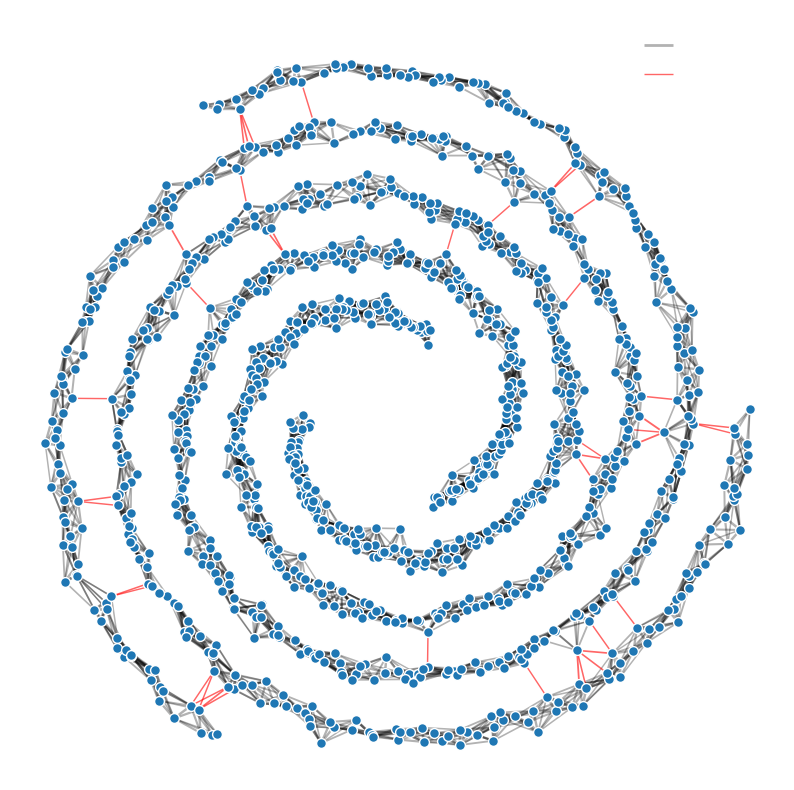

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
lc = LineCollection(lines, linewidths=widths, colors=colors)
ax.add_collection(lc)

scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    s=50,
    edgecolors="white",
    zorder=10,
)

ax.set_axis_off()

plt.savefig("figures/3_helices_graph.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [13]:
def simulation_assignment(P):

    n,k = P.shape

    rng = np.random.rand(n,1)
    cumsum = np.cumsum(P, axis=1)

    z = np.eye(k)[(rng < cumsum).argmax(axis=1)]

    return z

In [14]:
def compute_rcut(W, D, A):
    B = 1 - A
    return np.diag(B.T @ (W @ A)) / A.sum(axis=0)

def compute_ncut(W, D, A):
    B = 1 - A
    return np.diag(B.T @ (W @ A)) / (A.T @ D)


In [15]:
def monte_carlo_expected_cut(P, W, D, n_samples=400, cut_type="rcut"):
    estimate = 0.0
    std = 0.0

    for _ in range(n_samples):
        A = simulation_assignment(P)
        if cut_type == "rcut":
            cut = compute_rcut(W,D, A)
        elif cut_type == "ncut":
            cut = compute_ncut(W,D, A)
        else:
            raise ValueError(f"cut_type {cut_type} not supported")
        estimate += cut
        std += cut**2

    estimate /= n_samples
    std /= n_samples
        
    return estimate, (std - estimate **2)**0.5

In [ ]:
mc_means = []
mc_stds = []

for tau in temperatures:
    P = softmax(logits / tau, axis=1)

    mc_val, mc_std = monte_carlo_expected_cut(P, W, D, MC_NUM_SAMPLES, cut_type="rcut")

    mc_means.append(mc_val)
    mc_stds.append(mc_std)

    print(f"{tau:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


0.0001  |  11.5230  |  0.0010  
0.0001  |  11.5230  |  0.0017  
0.0002  |  11.5231  |  0.0027  
0.0002  |  11.5232  |  0.0037  
0.0003  |  11.5233  |  0.0049  
0.0003  |  11.5236  |  0.0060  
0.0004  |  11.5238  |  0.0070  
0.0005  |  11.5242  |  0.0079  
0.0007  |  11.5247  |  0.0089  
0.0008  |  11.5252  |  0.0097  
0.0010  |  11.5258  |  0.0106  
0.0013  |  11.5265  |  0.0117  
0.0017  |  11.5272  |  0.0129  
0.0021  |  11.5279  |  0.0143  
0.0027  |  11.5287  |  0.0158  
0.0034  |  11.5296  |  0.0177  
0.0042  |  11.5303  |  0.0198  
0.0054  |  11.5312  |  0.0225  
0.0068  |  11.5322  |  0.0262  
0.0086  |  11.5330  |  0.0302  
0.0108  |  11.5334  |  0.0350  
0.0137  |  11.5335  |  0.0401  
0.0173  |  11.5332  |  0.0449  
0.0218  |  11.5317  |  0.0500  
0.0276  |  11.5303  |  0.0554  
0.0349  |  11.5276  |  0.0614  
0.0441  |  11.5258  |  0.0673  
0.0557  |  11.5231  |  0.0747  
0.0704  |  11.5208  |  0.0832  
0.0890  |  11.5188  |  0.0919  
0.1124  |  11.5175  |  0.1021  
0.1421  

In [14]:
mc_m = np.array(mc_means)
mc_s = np.array(mc_stds)

In [ ]:
np.save("./buckets/checkpoints/hycut_mc_mean.npy", mc_m)
np.save("./buckets/checkpoints/hycut_mc_std.npy", mc_s)
np.save("./buckets/checkpoints/hycut_mc_tau.npy", temperatures)

In [17]:
mc_m.shape, mc_s.shape

((60, 3), (60, 3))

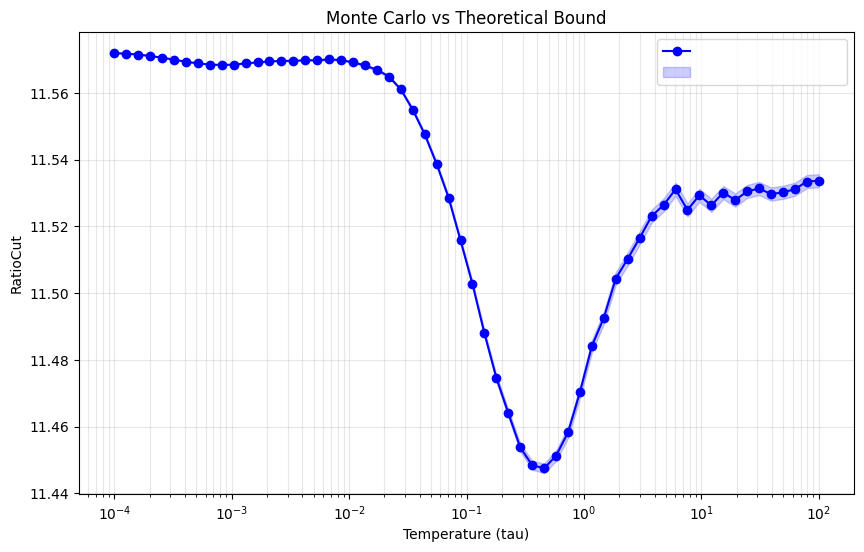

In [26]:
plt.figure(figsize=(10, 6))
    
k = 0

plt.plot(temperatures, mc_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures, mc_m[:,k] - mc_s[:,k]/MC_NUM_SAMPLES**.5, mc_m[:,k] + mc_s[:,k]/MC_NUM_SAMPLES**.5, 
                    color='blue', alpha=0.2, label=' '*8)

# plt.plot(temperatures, bound_vals, 's--', label='Paper Bound (Upper)', color='red')

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel('Temperature (tau)')
plt.ylabel('RatioCut')
plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [66]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(N -2)
b = 1.
c = 2.

estimate = []
prcut_estimate= []
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    omega = P.sum(0)
    alpha_bar = (P**2 /omega[None,1]).sum(0)
    var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    # w_p = -np.diag(P.T@(W@np.log(1e-6+P)))
    # prcut_estimate.append(np.sum(w_p / P.sum(0))/2)
    prcut_estimate.append(w_p / P.sum(0))
    # estimate.append(np.sum(w_p * sp_hyp2f1(a,b,c, P.mean(0)) )/2)
    estimate.append(w_p * sp_hyp2f1(a,b,c, P.mean(0)))
    vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

estimate = np.array(estimate)
prcut_estimate = np.array(prcut_estimate)

In [39]:
linear_t = np.linspace(0,1, 100)

In [ ]:
true_P = np.eye(K)[y_true]

In [53]:
t_mc_means = []
t_mc_stds = []


for t in linear_t:
    P = (1-t) * softmax(logits, axis=1) + t * true_P
    mc_val, mc_std = monte_carlo_expected_cut(P, W, MC_NUM_SAMPLES)

    t_mc_means.append(mc_val)
    t_mc_stds.append(mc_std)

    print(f"{t:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


0.0000  |  11.5212  |  0.2244  
0.0101  |  11.5195  |  0.2253  
0.0202  |  11.5160  |  0.2262  
0.0303  |  11.5122  |  0.2283  
0.0404  |  11.5055  |  0.2278  
0.0505  |  11.4976  |  0.2299  
0.0606  |  11.4879  |  0.2290  
0.0707  |  11.4764  |  0.2323  
0.0808  |  11.4646  |  0.2312  
0.0909  |  11.4510  |  0.2329  
0.1010  |  11.4354  |  0.2332  
0.1111  |  11.4176  |  0.2346  
0.1212  |  11.3992  |  0.2357  
0.1313  |  11.3792  |  0.2377  
0.1414  |  11.3578  |  0.2382  
0.1515  |  11.3334  |  0.2394  
0.1616  |  11.3080  |  0.2399  
0.1717  |  11.2834  |  0.2408  
0.1818  |  11.2552  |  0.2418  
0.1919  |  11.2256  |  0.2443  
0.2020  |  11.1947  |  0.2452  
0.2121  |  11.1614  |  0.2470  
0.2222  |  11.1279  |  0.2490  
0.2323  |  11.0910  |  0.2500  
0.2424  |  11.0553  |  0.2520  
0.2525  |  11.0154  |  0.2525  
0.2626  |  10.9756  |  0.2534  
0.2727  |  10.9335  |  0.2565  
0.2828  |  10.8900  |  0.2557  
0.2929  |  10.8449  |  0.2586  
0.3030  |  10.7989  |  0.2595  
0.3131  

/tmp/ipykernel_140465/314688211.py:16: RuntimeWarning: invalid value encountered in sqrt
  return estimate, (std - estimate **2)**0.5


In [55]:
t_mc_m = np.array(t_mc_means)
t_mc_s = np.array(t_mc_stds)

In [56]:
np.save("./buckets/checkpoints/hycut_t_mc_mean.npy", t_mc_m)
np.save("./buckets/checkpoints/hycut_t_mc_std.npy", t_mc_s)
np.save("./buckets/checkpoints/hycut_mc_t.npy", linear_t)

In [57]:
t_mc_m.shape, t_mc_s.shape

((100, 3), (100, 3))

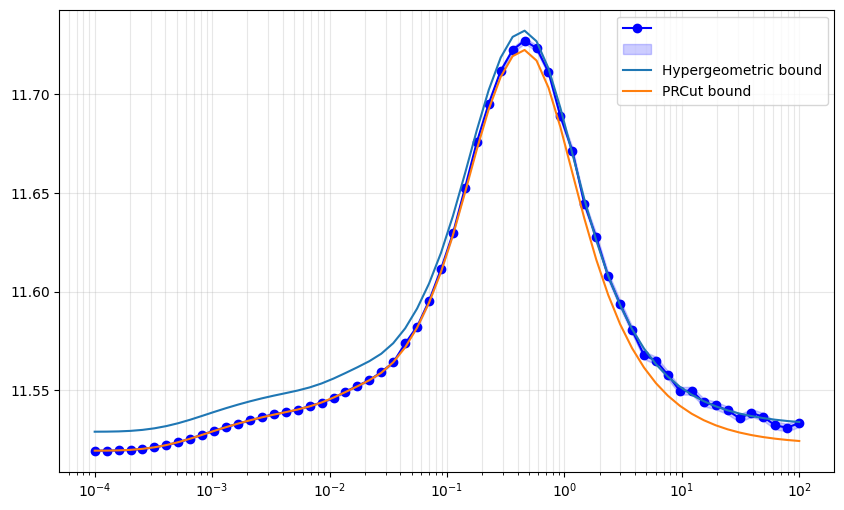

In [73]:
plt.figure(figsize=(10, 6))
k = 1
plt.plot(temperatures, mc_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures, mc_m[:,k] - mc_s[:,k]/MC_NUM_SAMPLES**.5, mc_m[:,k] + mc_s[:,k]/MC_NUM_SAMPLES**.5, 
                    color='blue', alpha=0.2, label=' '*8)



plt.plot(temperatures, estimate[:,k], label="Hypergeometric bound")

plt.plot(temperatures, prcut_estimate[:,k], label="PRCut bound")

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [68]:
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

a = -(N -2)
b = 1.
c = 2.

t_estimate = []
t_prcut_estimate= []
vs = []
for t in linear_t:
    P = (1-t) * softmax(logits/10.0, axis=1) + t * true_P
    omega = P.sum(0)
    alpha_bar = (P**2 /omega[None,1]).sum(0)
    var_zero = ((P * np.square(P-alpha_bar)).sum(0) / omega).sum()
    w_p = np.diag(P.T@(W@(1-P)))
    # w_p = -np.diag(P.T@(W@np.log(1e-6+P)))
    # prcut_estimate.append(np.sum(w_p / P.sum(0))/2)
    t_prcut_estimate.append(w_p / P.sum(0))
    # estimate.append(np.sum(w_p * sp_hyp2f1(a,b,c, P.mean(0)) )/2)
    t_estimate.append(w_p * sp_hyp2f1(a,b,c, P.mean(0)))
    vs.append(np.var(P,axis=1).sum())
    # vs.append(var_zero)

t_estimate = np.array(t_estimate)
t_prcut_estimate = np.array(t_prcut_estimate)

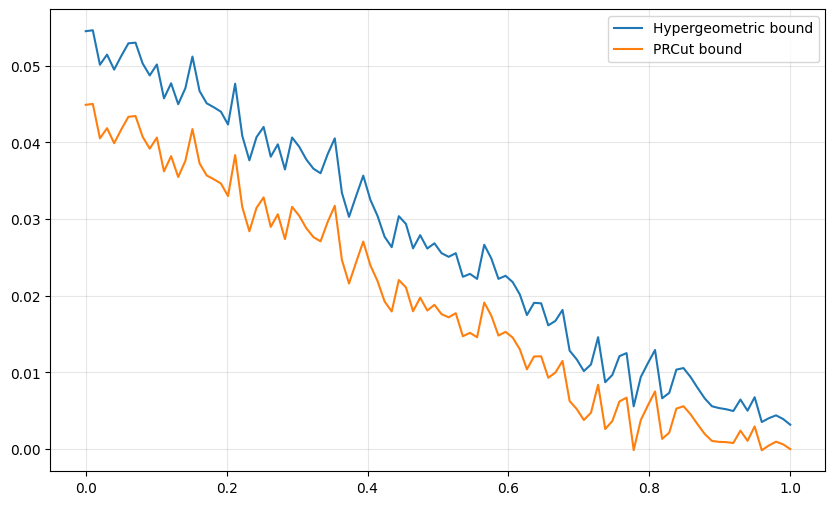

In [ ]:
plt.figure(figsize=(10, 6))
k = 0

plt.plot(linear_t, t_estimate[:,k]-t_mc_m[:,k], label="Hypergeometric bound")

plt.plot(linear_t, t_prcut_estimate[:,k]-t_mc_m[:,k], label="PRCut bound")


plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

/tmp/ipykernel_140465/1645535779.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


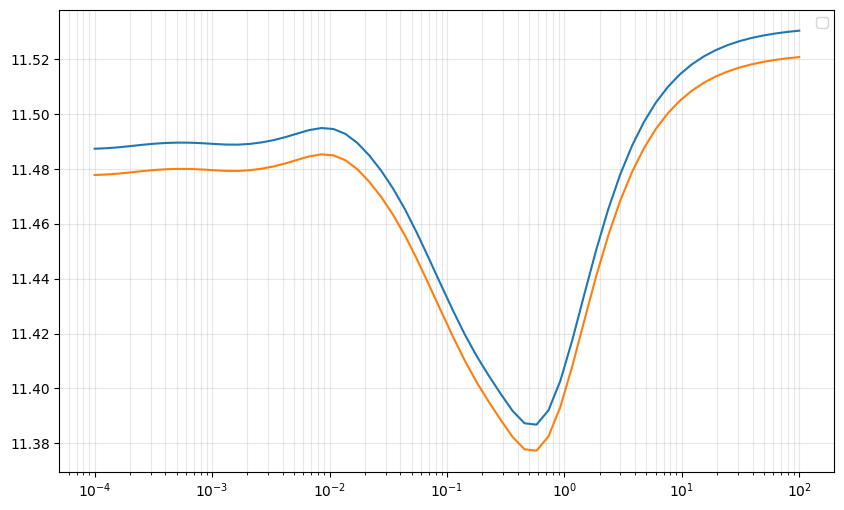

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, estimate[:,k])
plt.plot(temperatures, prcut_estimate[:,k])
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

/tmp/ipykernel_9512/1368385446.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


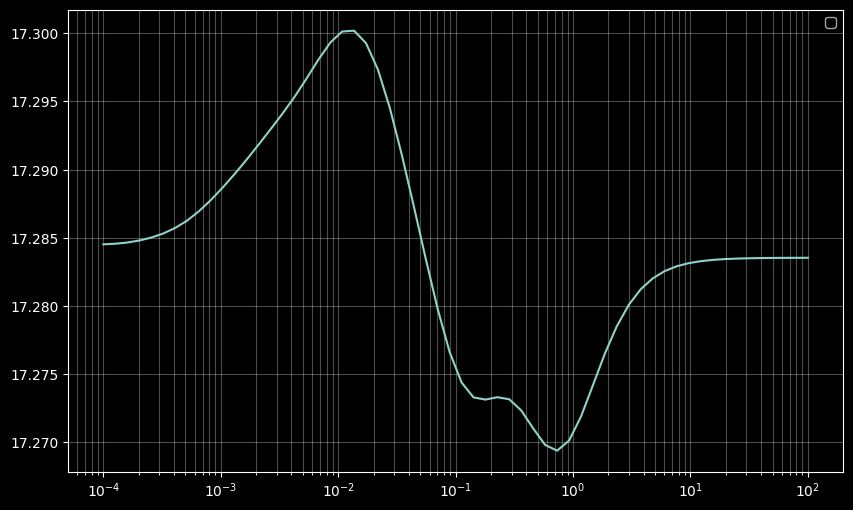

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, prcut_estimate)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [ ]:
def get_safe_zero_aware_variance(P):
    """
    Computes Var_omega(alpha) safely.
    Weights w_i = p_i(1-p_i).
    """
    # 1. Weights: Zero-aware (vanish at 0 and 1)
    W_weights = P * (1.0 - P) # (N, K)
    
    # 2. Sum of weights (Omega)
    Omega = np.sum(W_weights, axis=0) # (K,)
    
    # 3. Handle collapsed weights (Hard assignments)
    # If Omega is tiny, variance is effectively 0.
    valid_mask = Omega > 1e-9
    
    # 4. Weighted Mean: Sum(w * p) / Sum(w)
    # Note: p is P itself.
    weighted_mean = np.zeros_like(Omega)
    num_mean = np.sum(W_weights * P, axis=0)
    weighted_mean[valid_mask] = num_mean[valid_mask] / Omega[valid_mask]
    
    # 5. Weighted Variance: Sum(w * (p - mu)^2) / Sum(w)
    # Broadcast weighted_mean correctly (1, K)
    diff = P - weighted_mean.reshape(1, -1)
    num_var = np.sum(W_weights * (diff**2), axis=0)
    
    weighted_var = np.zeros_like(Omega)
    weighted_var[valid_mask] = num_var[valid_mask] / Omega[valid_mask]
    
    return weighted_var, valid_mask

/tmp/ipykernel_9512/3315488008.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


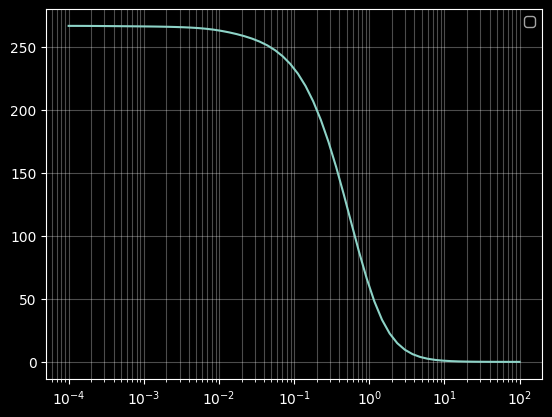

In [ ]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [ ]:
vs = []
for tau in temperatures:
    P = softmax(logits / tau, axis=1)
    vs.append(get_safe_zero_aware_variance(P)[0].sum())

/tmp/ipykernel_9512/3315488008.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


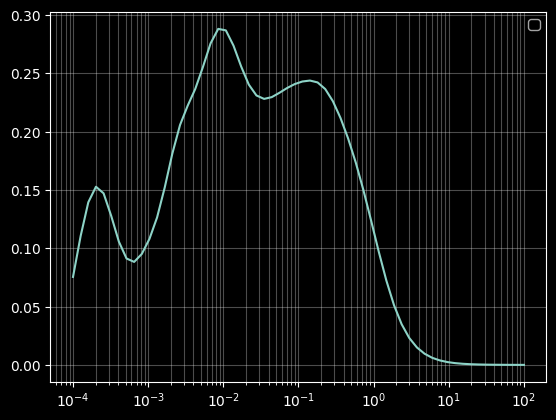

In [ ]:
plt.plot(temperatures, vs)
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

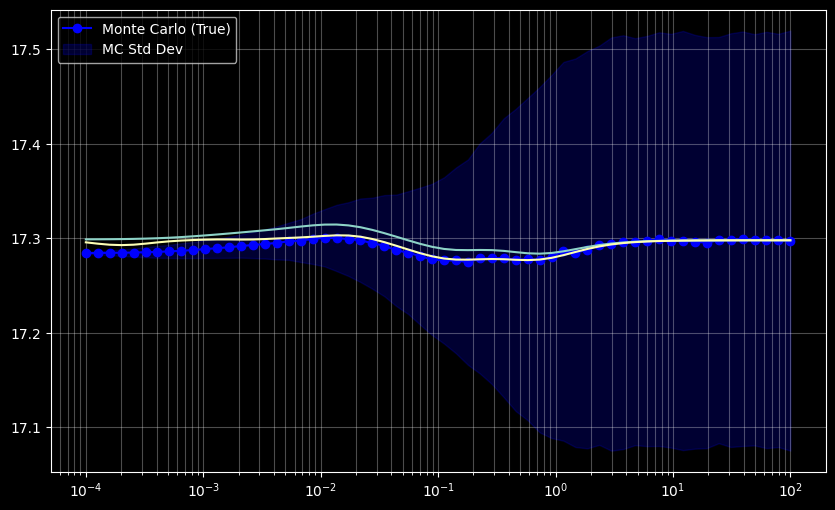

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(temperatures, mc_m, 'o-', label='Monte Carlo (True)', color='blue')
plt.fill_between(temperatures, mc_m - mc_s, mc_m + mc_s, 
                    color='blue', alpha=0.2, label='MC Std Dev')
plt.plot(temperatures, estimate)
plt.plot(temperatures, estimate - np.array(vs)/24.0)

# plt.plot(temperatures, vs)
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.xlabel('Temperature (tau)')
# plt.ylabel('RatioCut')
# plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

(array([  2.,   0.,   3.,   0.,   2.,   5.,   4.,   8.,  14.,  28.,  35.,
         50.,  45.,  45.,  30.,  52.,  86., 167., 152., 132.,  65.,  56.,
         41.,  37.,  34.,  18.,  11.,  14.,  13.,  21.,  15.,  15.]),
 array([ 7.59565271,  8.12838447,  8.66111622,  9.19384798,  9.72657974,
        10.2593115 , 10.79204326, 11.32477502, 11.85750678, 12.39023853,
        12.92297029, 13.45570205, 13.98843381, 14.52116557, 15.05389733,
        15.58662908, 16.11936084, 16.6520926 , 17.18482436, 17.71755612,
        18.25028788, 18.78301964, 19.31575139, 19.84848315, 20.38121491,
        20.91394667, 21.44667843, 21.97941019, 22.51214194, 23.0448737 ,
        23.57760546, 24.11033722, 24.64306898]),
 <BarContainer object of 32 artists>)

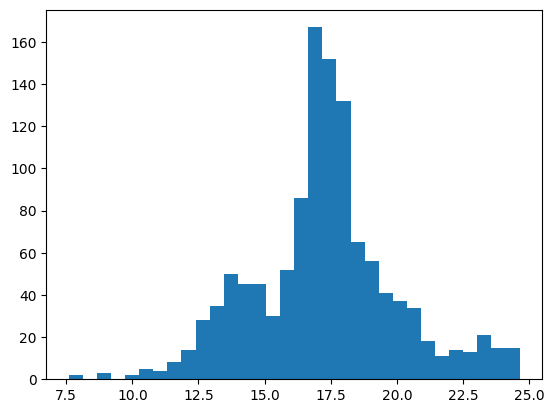

In [16]:
plt.hist(D,bins=32)

In [ ]:
mc_n_means = []
mc_n_stds = []

for tau in temperatures:
    P = softmax(logits / tau, axis=1)

    mc_val, mc_std = monte_carlo_expected_cut(P, W, D, MC_NUM_SAMPLES, cut_type="ncut")

    mc_n_means.append(mc_val)
    mc_n_stds.append(mc_std)

    print(f"{tau:.4f}  |  {mc_val.mean():.4f}  |  {mc_std.mean():.4f}  ")


0.0001  |  0.6667  |  0.0001  
0.0001  |  0.6667  |  0.0001  
0.0002  |  0.6667  |  0.0002  
0.0002  |  0.6667  |  0.0002  
0.0003  |  0.6667  |  0.0003  
0.0003  |  0.6667  |  0.0004  
0.0004  |  0.6667  |  0.0005  
0.0005  |  0.6668  |  0.0005  
0.0007  |  0.6668  |  0.0006  
0.0008  |  0.6668  |  0.0006  
0.0010  |  0.6668  |  0.0007  
0.0013  |  0.6669  |  0.0007  
0.0017  |  0.6669  |  0.0008  
0.0021  |  0.6670  |  0.0008  
0.0027  |  0.6670  |  0.0009  
0.0034  |  0.6671  |  0.0010  
0.0042  |  0.6671  |  0.0011  
0.0054  |  0.6672  |  0.0013  
0.0068  |  0.6672  |  0.0015  
0.0086  |  0.6673  |  0.0018  
0.0108  |  0.6673  |  0.0021  
0.0137  |  0.6673  |  0.0024  
0.0173  |  0.6673  |  0.0027  
0.0218  |  0.6672  |  0.0030  
0.0276  |  0.6671  |  0.0034  
0.0349  |  0.6670  |  0.0037  
0.0441  |  0.6668  |  0.0040  
0.0557  |  0.6667  |  0.0045  
0.0704  |  0.6666  |  0.0049  
0.0890  |  0.6664  |  0.0054  
0.1124  |  0.6664  |  0.0060  


In [ ]:
mc_n_m = np.array(mc_n_means)
mc_n_s = np.array(mc_n_stds)

NameError: name 'np' is not defined

In [ ]:

np.save("./buckets/checkpoints/hycut_t_mc_n_mean.npy", t_mc_m)
np.save("./buckets/checkpoints/hycut_t_mc_n_std.npy", t_mc_s)
np.save("./buckets/checkpoints/hycut_mc_n_t.npy", linear_t)

In [ ]:
plt.figure(figsize=(10, 6))
    
k = 0

plt.plot(temperatures, mc_m[:,k], 'o-', label='    '*8, color='blue')

plt.fill_between(temperatures, mc_m[:,k] - mc_s[:,k]/MC_NUM_SAMPLES**.5, mc_m[:,k] + mc_s[:,k]/MC_NUM_SAMPLES**.5, 
                    color='blue', alpha=0.2, label=' '*8)

# plt.plot(temperatures, bound_vals, 's--', label='Paper Bound (Upper)', color='red')

plt.xscale('log')
# plt.gca().invert_xaxis()
plt.xlabel('Temperature (tau)')
plt.ylabel('RatioCut')
plt.title('Monte Carlo vs Theoretical Bound')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [ ]:
# C. Plottin
plt.figure(figsize=(10, 6))
plt.plot(
    temperatures,
    mc_results,
    "o-",
    label="Monte Carlo Estimate (True Expected RatioCut)",
    color="blue",
)
plt.plot(
    temperatures,
    bound_results,
    "s--",
    label="Probabilistic Upper Bound (Theorem 1)",
    color="red",
)

plt.xscale("log")
plt.gca().invert_xaxis()  # High temp (left) to Low temp (right)
plt.xlabel(
    "Temperature (tau) [Log Scale] \n <-- Softer Assignments ... Harder Assignments -->"
)
plt.ylabel("RatioCut Value")
plt.title(
    "Validation of Probabilistic Bounds vs True Expected Cut\n(3 Helices Dataset)"
)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def compute_theoretical_bound(P, W, s_type="ratio"):

    
    n, k = P.shape
    m = n - 2  # As per definition in paper for GPB
    # 1. Compute M_{il}: The 'numerator' part (expected cut edges)
    # This is efficiently calculated via matrix operations.
    # M_il = (W * P_other)_il * P_il ??? No.
    # M_{il} = sum_j W_{ij} P_{il} (1 - P_{jl})
    #        = P_{il} * sum_j W_{ij} (1 - P_{jl})

    # Probability that neighbor j is NOT in cluster l
    P_complement = 1.0 - P

    # Weighted sum of neighbors not in cluster l
    W_dot_P_comp = W @ P_complement

    # M matrix: [N x K]
    M = P * W_dot_P_comp

    # 2. Compute Phi_l(s_i): The 'denominator' bound
    # For RatioCut, s_i = 1 for all i. q = 1. beta = 1.
    # The bound depends on the Mean Assignment alpha_bar for cluster l.

    bound_val = 0.0

    if s_type == "ratio":
        # Calculate mean assignment prob for each cluster: alpha_bar_l
        # The paper defines alpha_bar over the 'other' nodes, but for large N,
        # 1/m * Sum_{all} P_il is the standard approximation.
        alpha_bar = np.mean(P, axis=0)  # [K]

        for l in range(K):
            # Compute H function for this cluster's occupancy
            # For RatioCut: q=1, beta=1
            H_val = horner_hypergeometric_ratio_cut(
                m, alpha_bar[l], q=1, beta=1
            )

            # Sum over all nodes i
            # For RatioCut, Phi is constant for all i in cluster l (since s_i=1)
            # contribution = Sum_i M_{il} * H_val

            cut_mass_l = np.sum(M[:, l])
            bound_val += cut_mass_l * H_val

    return 0.5 * bound_val  # GraphCut is 1/2 sum VolCut

In [ ]:
def horner_hypergeometric_ratio_cut(m, alpha_bar, q=1, beta=1):
    """
    Computes the Hypergeometric envelope H_beta(q; alpha, m) for RatioCut.
    Using Eq (11) and Algorithm 1 logic (Horner's rule/Finite Sum).

    For RatioCut: q=1, beta=1.
    c = q/beta + 1 = 2.

    We need to compute: (1/q) * 2F1(-m, 1; c; alpha_bar)
    Since -m is a negative integer, the series truncates at term m.
    """
    # 2F1(-m, 1; c; z) = sum_{k=0}^{m} [(-m)_k * (1)_k] / [(c)_k * k!] * z^k
    #                  = sum_{k=0}^{m} [(-m)_k] / [(c)_k] * z^k

    c = (q / beta) + 1
    z = alpha_bar

    # We evaluate the polynomial using a loop for stability (Algorithm 1)
    # Series: 1 + T1 + T2 + ...
    # T_k = T_{k-1} * (-m + k - 1) * z / (c + k - 1)

    current_term = 1.0
    total_sum = 1.0

    # Note: For very large m, direct computation can be numerically sensitive.
    # The paper suggests early exit or log-domain, but for N=1200
    # and standard float64, this summation usually holds up well enough for demo.

    for k in range(1, m + 1):
        # Update factor derived from ratio of coefficients
        factor = (-m + k - 1) * z / (c + k - 1)
        current_term *= factor
        total_sum += current_term

        # Optimization: Early exit if term vanishes (precision floor)
        if abs(current_term) < 1e-15:
            break

    return (1.0 / q) * total_sum




def run_simulation():
    # A. Setup Data
    

    for tau in temperatures:
        # 1. Softmax with temperature
        P = softmax(logits / tau, axis=1)

        # 2. Monte Carlo Estimate (The "True" Expected Cut)
        mc_val = monte_carlo_expected_cut(P, W, n_samples=30)

        # 3. Theoretical Upper Bound
        bound_val = compute_theoretical_bound(P, W, s_type="ratio")

        mc_results.append(mc_val)
        bound_results.append(bound_val)

        print(f"{tau:.4f}     | {mc_val:.4f}          | {bound_val:.4f}")

    # C. Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(
        temperatures,
        mc_results,
        "o-",
        label="Monte Carlo Estimate (True Expected RatioCut)",
        color="blue",
    )
    plt.plot(
        temperatures,
        bound_results,
        "s--",
        label="Probabilistic Upper Bound (Theorem 1)",
        color="red",
    )

    plt.xscale("log")
    plt.gca().invert_xaxis()  # High temp (left) to Low temp (right)
    plt.xlabel(
        "Temperature (tau) [Log Scale] \n <-- Softer Assignments ... Harder Assignments -->"
    )
    plt.ylabel("RatioCut Value")
    plt.title(
        "Validation of Probabilistic Bounds vs True Expected Cut\n(3 Helices Dataset)"
    )
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.3)

    plt.tight_layout()
    plt.show()


Generating 3 Helices (N=1200)...
Computing Affinity Matrix (RBF)...
Temp       | MC (True)       | Bound (Ours)   
---------------------------------------------
10.0000     | 0.0000          | -1601064592320792579070597133588087221287233919164287190688113014957859673203058549214815591897718636642608052978182674242941461383348224.0000
7.8476     | 0.0000          | 221218349202363235048523342188563944201723652091920998363657418423574725917753215827046772934859446596336214513940900004739601636786176.0000
6.1585     | 0.0000          | -536788184523569464012291913551381604409695480961504950661752674289011506527994381446670239846749204718061149942521908097083722073899008.0000
4.8329     | 0.0000          | -1976789401995814485753204308151931707485213849165555512277294350070876616798673265359564308822454173847395595775482753906682281125216256.0000
3.7927     | 0.0000          | 379370949712209805598713547374287307116914459174095116344559421833225060937949289399935673968733573654372588804598

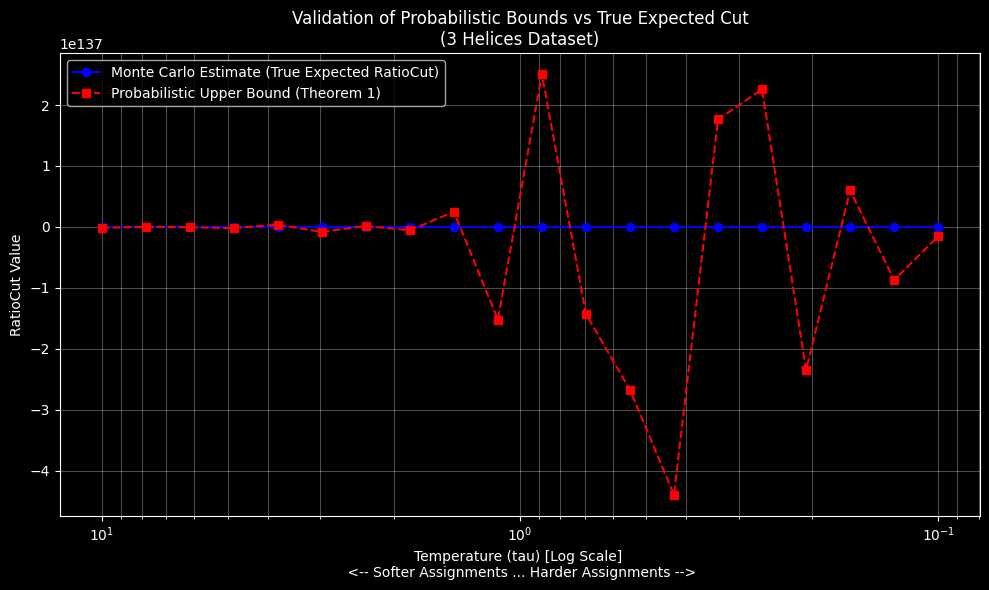

In [ ]:
run_simulation()

In [ ]:

print(f"{'Temp':<10} | {'MC (True)':<15} | {'Bound (Ours)':<15}")
print("-" * 45)